# DLIM TP4 CycleGAN

*v20231017-1949*
## Introduction

*Bienvenu dans le TP4 de DLIM.*

Ce TP ressemble beaucoup à un TP à trous. Il est basé sur un tutoriel assez facile à trouver pour Tensorflow, donc l'objectif est de bien comprendre les différentes étapes plutôt que d'aller copier-coller du code depuis n'importe où.

Bref, aujourd'hui nous allons implémenter l'architecture **CycleGAN**.

*Les images montrées dans ce notebook sont celles des auteurs originaux.*

### Important
Le travail à réaliser sera indiqué par :

<hr>
👷 <b>Au travail !</b>
Complétez le code ci-dessous.
<hr>

### À propos de *CycleGAN*

**CycleGAN** est une architecture, ou plutôt une stratégie d'apprentissage, proposée par Jun-Yan Zhu, Taesung Park, Phillip Isola et Alexei A. Efros (UC Berkeley) en 2017.

- [Article](https://arxiv.org/pdf/1703.10593.pdf)
- [Implementation originale](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) (contient aussi une implémentation de Pix2Pix)

*CycleGAN* permet (dans une certaine mesure) de convertir des images entre des domaines $X$ (exemple : photos de chevaux) et $Y$ (exemple : photos de zèbres).

![Illustration des conversions possibles avec CycleGAN](https://camo.githubusercontent.com/16fa02525bf502bec1aac77a3eb5b96928b0f25d73f7d9dedcc041ba28c38751/68747470733a2f2f6a756e79616e7a2e6769746875622e696f2f4379636c6547414e2f696d616765732f7465617365725f686967685f7265732e6a7067)

#### Architecture CycleGAN
CycleGAN a proposé d'ajouter une contrainte de **"cohérence cyclique"** pour améliorer la qualité des images générées, ce qui a également permis de travailler en **fournissant au réseau des ensembles d'images non triés plutôt que des paires d'images annotées**. Cette possibilité de réaliser un apprentissage avec des données faiblement annotées est particulièrement intéressante car elle permet de tirer profit d'un grand volume de données.

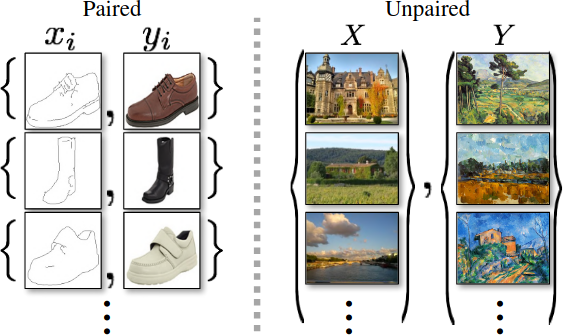


Le principe est résumé en images dans l'article.

**Commençons par regarder l'architecture.**
CycleGAN utilise :
- **2 générateurs** **$G$** (qui transforme les images de $X$ en images de $Y$ tout en évitant de modifier les images de $Y$) et **$F$** (qui fait la même chose mais de $Y$ vers $X$) ;
- et **2 discriminateurs** **$D_X$** (qui détecte si une image est un original de $X$ ou un faux $F(y)$, $y \in Y$) et **$D_Y$** (qui fait la même chose pour $Y$).

Les **2 générateurs partagent la même architecture**, de même que les **2 discriminateurs sont basés sur la même structure de réseau**. Cependant, ils auront **tous des paramètres différents à l'issue de l'apprentissage.**

*(J'aurais préféré utiliser une notation avec $G_{X→Y}$  et $G_{Y→X}$ au lieu de $G$ et $F$ mais nous allons conserver les notations originales pour éviter les confusions.)*



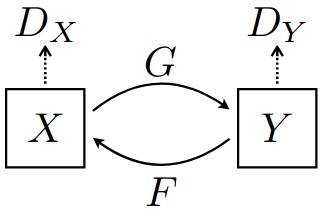

#### Fonctions de coût
CycleGAN utilise 4 types de fonctions de coût (pour notre implémentation).
1. La fonction de coût des **discriminateurs** $\mathcal{L}_{disc}$ qui pénalise les erreurs commises par chaque discriminateur et force les générateurs à produire des images qui imitent leur domaine cible.
2. La fonction de coût des **générateurs** $\mathcal{L}_{gen}$ au regard de leur capacité à tromper les discriminateurs (typique de l'apprentissage adverse).
3. La fonction de coût de **"cohérence cyclique" des générateurs** $\mathcal{L}_{cycl}$(illustrée ci-dessous) qui impose que $F(G(x)) \approx x, x \in X$ ou, réciproquement, $G(F(x)) \approx y, y \in Y$ : ceci permet de forcer les générateurs à conserver la structure de l'image.
4. Une fonction de coût de **"préservation d'identité" des générateurs** $\mathcal{L}_{ident}$ qui impose que $G(y) \approx y, y \in Y$ : cette fonction n'est pas dans l'article original et permet d'encourager les générateurs à produire des images qui respectent la structure des images d'entrée (c'est mon interprétation personnelle).

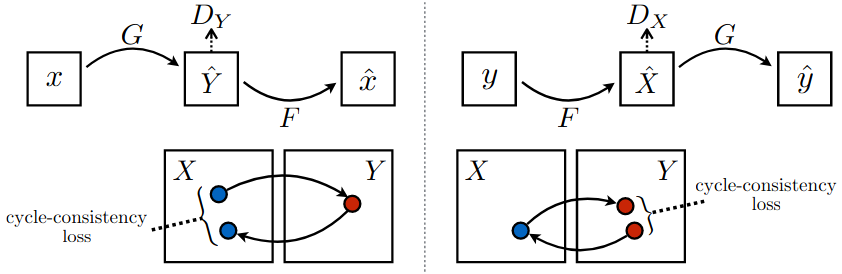

### Travail à réaliser

Pour mener à bien ce TP, vous aurez besoin de coder progressivement l'architecture CycleGAN.

**Voici les grandes étapes que nous vous conseillons de suivre.** Pour chacun de ces étapes, nous allons vous présenter le résultat attendu et vous guider pour comprendre les notions qui nous semblent importantes à comprendre (tout en cachant sous le tapis celles qui sont plus obscures).

1. Compléter le **code de préparation des données**.
2. Compléter l'**architecture** des **2 réseaux** $G$ (générateur) et $D$ (discriminateur).
3. Compléter le **code** des **4 fonctions de coût**.
4. **Connecter les différentes parties** et **coder la boucle d'apprentissage**.
5. Lancer l'**apprentissage**.
6. **Analyser les résultats** (historique, prédiction sur des images de test).
7. **Sauvegarder** tout.

*PS : N'hésitez pas à regarder l'[article original](http://arxiv.org/abs/1703.10593) pour plus d'informations.*

## (1) Imports et préparation des données


### Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

In [ ]:
# On affiche la version de Tensorflow pour détecter d'éventuels problèmes
tf.__version__

'2.17.0'

### We need to reimplement here the instance normalization which came from a package which is now broken…

In [ ]:
# No need to understand this code, just run it
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Préparation du jeu de données

Nous allons utiliser un jeu de données déjà préparé au format "tensorflow datasets". Ça nous permettra un entraînement assez efficace.

Nous vous proposons de tester avec le jeu de données "Horse2Zebra" mais vous pouvez choisir un autre jeu de données ici : https://www.tensorflow.org/datasets/catalog/cycle_gan

In [ ]:
# Load the horse-zebra dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

Vous ne devriez pas avoir besoin de modifier les valeurs ci-dessous.

- `buffer_size` indique le nombre de données mise en cache par les générateurs de données
- `batch_size` indique le nombre d'images qui vont être traitées à chaque étape avant d'appliquer la descente de gradient. Pour des raisons de convergence et de mémoire, vous devriez laisser cette valeur à 1. **Attention : comme on a 2 générateurs on traitera une image de $X$ et une image de $Y$ en même temps à chaque étape.**

In [ ]:
buffer_size = 256
batch_size = 1

👷 **Au travail !** Complétez le fonction `normalize_img` ci-dessous.

In [ ]:
def normalize_img(img):
    # cast numpy content to tensorflow values
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    img = img / 127.5 - 1
    return img

def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

def denormalize(tensor):
  # Useful when visualizing image: take result image and make it viewable
  # `tensor` is a tf.float32 image with values in the range [-1, 1]
  return (tensor.numpy() * 127.5 + 127.5).astype(np.uint8)

### Création des objets `Dataset`
Nous allons appliquer le pré-traitement des données aux différents jeux de données qui vont être utiles :
- jeu d'apprentissage pour images $X$ ("horses")
- jeu d'apprentissage pour images $Y$ ("zebras")
- jeu de test pour images $X$ ("horses")
- jeu de test pour images $Y$ ("zebras")

**Attention pour les images de test on ne fait que normaliser la taille et le domaine des images.**

👷 **Au travail !** Complétez le code ci-dessous.

In [ ]:
# Apply the preprocessing operations to the training data
train_horses = (
    train_horses.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_zebras = (
    train_zebras.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)#???  # FIXME

# Apply the preprocessing operations to the test data
test_horses = (
    test_horses.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)  # FIXME

test_zebras = (
    test_zebras.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)  # FIXME

In [ ]:
### Affichage de quelques exemples

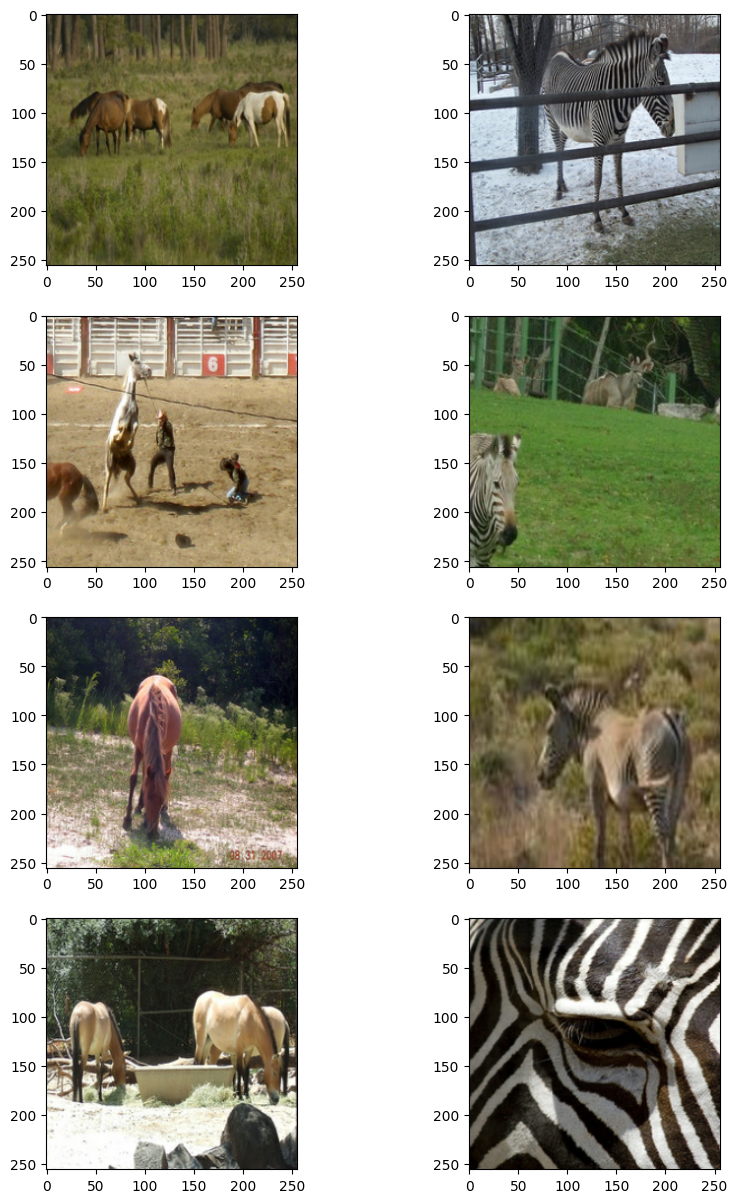

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, (horses_batch, zebras_batch) in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = denormalize(horses_batch[0])
    zebra = denormalize(zebras_batch[0])
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

## (2) Implémentation des réseaux de base ($G$ et $D$)
Nous utiliserons l'API fonctionnelle de Keras par simplicité car ces réseaux sont assez simples dans leur structure : ils se résument à un empilement de couches convolutionnelles (CNN).

L'API fonctionnelle de Keras permet de définir facilement un modèle à l'aide de brique élémentaire simples (1 entrée → 1 sortie), comme par exemple :
```python
# Simple MNIST classifier
inputs = keras.Input(shape=(784,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()
```
Affichage produit :
```
Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
=================================================================
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
```
*Vous pouvez aussi utiliser `keras.utils.plot_model()` pour dessiner le graphe du modèle.*

### Blocs de base pour les générateurs et discriminateurs de CycleGAN

👷 **Au travail !**
Complétez le code ci-dessous.

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])  # FIXME what is the combination operation in residual blocks?
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
     # FIXME create a convolutional layer with appropriate parameters
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
     # FIXME create a deconvolution layer with appropriate parameters
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

### Architecture des générateurs
Les deux générateurs possèdent la même architecture convolutionnelle :
- 1 bloc de préparation de l'entrée
- 2 blocs de *downsampling*
- 9 blocs résiduels
- 2 blocs d'*upsampling*
- 1 bloc de finalisation de la sortie

En résumé, l'architecture est la suivante :
```
c7s1-64 ==> Conv block with `relu` activation, filter size of 7
d128 ====|
         |-> 2 downsampling blocks
d256 ====|
R256 ====|
R256     |
R256     |
R256     |
R256     |-> 9 residual blocks
R256     |
R256     |
R256     |
R256 ====|
u128 ====|
         |-> 2 upsampling blocks
u64  ====|
c7s1-3 => Last conv block with `tanh` activation, filter size of 7.
```

👷 **Au travail !**
Complétez le code ci-dessous.

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters=filters,
                      kernel_size=(7,7),
                      kernel_initializer=kernel_init
                      )(img_input) # FIXME add conv2d block with `filters` filters of shape 7x7 and no bias. Use `kernel_init` as initializer
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = layers.Downsampling(
            filters=filters,
            activation=layers.Activation("relu")
        ) # FIXME add downsampling layers with `filters` filters and relu activation

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = layers.residual_block(activation=layers.Activation("relu"))   # FIXME add residual blocks with relu activation

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = layers.Upsampling(filters=filters,
                              activation=layers.Activation("relu")) # FIXME add upsampling layers with `filters` filters and relu activation

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)
      # FIXME add a hyperbolic tangent activation

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
      # FIXME create model with inputs, outputs and name
    return model

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    # Conv2D Block with filters, kernel_size=7, padding='same', use_bias=False, kernel_initializer=kernel_init
    x = layers.Conv2D(
        filters,
        (7, 7),
        strides=(1, 1),
        padding="same",
        use_bias=False,
        kernel_initializer=kernel_init
    )(img_input)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x) # Apply InstanceNormalization to the output of Conv2D
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.LeakyReLU(0.2))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.ReLU())
           # FIXME add residual blocks with relu activation

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.ReLU())

    # Last conv2D block with filters=3, kernel_size=7, padding='same', use_bias=False, kernel_initializer=kernel_init
    x = layers.Conv2D(
        3,
        (7, 7),
        strides=(1, 1),
        padding="same",
        use_bias=False,
        kernel_initializer=kernel_init,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x) # Apply InstanceNormalization to the output of Conv2D
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

### Architecture des discriminateurs

Les discriminateurs suivent l'architecture suivante:
`C64->C128->C256->C512`

Les discriminateurs prédisent des cartes qui indiquent pour chaque pixels :
- `0` si le pixel est détecté comme généré
- `1` si le pixel est détecté comme original


👷 **Au travail !**
Complétez le code ci-dessous.

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:  # different stride for last layers
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)
     # FIXME add a conv2D layer with 1 output channel, (4,4) conv with (1, 1) stride and "same" padding

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

### Création des générateurs et des discriminateurs

In [ ]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

### Vérification des architectures

👷 **Au travail !**
Affichez l'architecture vos réseaux et vérifiez qu'on obtient bien les structures suivantes :


In [ ]:
gen_G.summary()
gen_F.summary()
disc_X.summary()
disc_Y.summary()

Model: "generator_G"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ generator_G_img_input     │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 256, 256, 64)   │          9,408 │ generator_G_img_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_19 │ (None, 256, 256, 64)   │              2 │ conv2d_21[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 256, 256, 64)   │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │         73,728 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_20 │ (None, 128, 128, 128)  │              2 │ conv2d_22[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 128, 128, 128)  │              0 │ instance_normalizatio… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        294,912 │ leaky_re_lu_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_21 │ (None, 64, 64, 256)    │              2 │ conv2d_23[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 64, 64, 256)    │              0 │ instance_normalizatio… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_6    │ (None, 66, 66, 256)    │              0 │ leaky_re_lu_11[0][0]   │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        589,824 │ reflection_padding2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_22 │ (None, 64, 64, 256)    │              2 │ conv2d_24[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 256)    │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_7    │ (None, 66, 66, 256)    │              0 │ re_lu[0][0]            │
│ (ReflectionPadding2D)     │                        │                │                        │
├──────────────────────

 Total params: 11,372,976 (43.38 MB)

 Trainable params: 11,372,976 (43.38 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_F"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ generator_F_img_input     │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 256, 256, 64)   │          9,408 │ generator_F_img_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_43 │ (None, 256, 256, 64)   │              2 │ conv2d_43[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 256, 256, 64)   │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 128, 128, 128)  │         73,728 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_44 │ (None, 128, 128, 128)  │              2 │ conv2d_44[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 128, 128, 128)  │              0 │ instance_normalizatio… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 64, 64, 256)    │        294,912 │ leaky_re_lu_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_45 │ (None, 64, 64, 256)    │              2 │ conv2d_45[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 64, 64, 256)    │              0 │ instance_normalizatio… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_24   │ (None, 66, 66, 256)    │              0 │ leaky_re_lu_13[0][0]   │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 64, 64, 256)    │        589,824 │ reflection_padding2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_46 │ (None, 64, 64, 256)    │              2 │ conv2d_46[0][0]        │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 64, 64, 256)    │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_25   │ (None, 66, 66, 256)    │              0 │ re_lu_11[0][0]         │
│ (ReflectionPadding2D)     │                        │                │                        │
├──────────────────────

 Total params: 11,372,976 (43.38 MB)

 Trainable params: 11,372,976 (43.38 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_X"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ discriminator_X_img_input            │ (None, 256, 256, 3)         │               0 │
│ (InputLayer)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 64, 64, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_67            │ (None, 64, 64, 128)         │               2 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_68            │ (None, 32, 32, 256)         │               2 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 32, 32, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_69            │ (None, 32, 32, 512)         │               2 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,847 (10.54 MB)

 Trainable params: 2,763,847 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_Y"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ discriminator_Y_img_input            │ (None, 256, 256, 3)         │               0 │
│ (InputLayer)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 64, 64, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_70            │ (None, 64, 64, 128)         │               2 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_71            │ (None, 32, 32, 256)         │               2 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 32, 32, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_72            │ (None, 32, 32, 512)         │               2 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,847 (10.54 MB)

 Trainable params: 2,763,847 (10.54 MB)

 Non-trainable params: 0 (0.00 B)


Pour les générateurs :
```
Model: "generator_G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
generator_G_img_input (InputLay [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (None, 262, 262, 3)  0           generator_G_img_input[0][0]      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        reflection_padding2d[0][0]       
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization[0][0]     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 73728       activation[0][0]                 
__________________________________________________________________________________________________
instance_normalization_1 (Insta (None, 128, 128, 128 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 128 0           instance_normalization_1[0][0]   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 256)  294912      activation_1[0][0]               
__________________________________________________________________________________________________
instance_normalization_2 (Insta (None, 64, 64, 256)  512         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 64, 64, 256)  0           instance_normalization_2[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 66, 66, 256)  0           activation_2[0][0]               
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
instance_normalization_3 (Insta (None, 64, 64, 256)  512         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 64, 64, 256)  0           instance_normalization_3[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_2 (Reflect (None, 66, 66, 256)  0           activation_3[0][0]               
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_2[0][0]     
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 64, 64, 256)  512         conv2d_4[0][0]                   
__________________________________________________________________________________________________
add (Add)                       (None, 64, 64, 256)  0           activation_2[0][0]               
                                                                 instance_normalization_4[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_3 (Reflect (None, 66, 66, 256)  0           add[0][0]                        
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_3[0][0]     
__________________________________________________________________________________________________
instance_normalization_5 (Insta (None, 64, 64, 256)  512         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64, 64, 256)  0           instance_normalization_5[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_4 (Reflect (None, 66, 66, 256)  0           activation_4[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_4[0][0]     
__________________________________________________________________________________________________
instance_normalization_6 (Insta (None, 64, 64, 256)  512         conv2d_6[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 64, 64, 256)  0           add[0][0]                        
                                                                 instance_normalization_6[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_5 (Reflect (None, 66, 66, 256)  0           add_1[0][0]                      
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_5[0][0]     
__________________________________________________________________________________________________
instance_normalization_7 (Insta (None, 64, 64, 256)  512         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 64, 64, 256)  0           instance_normalization_7[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_6 (Reflect (None, 66, 66, 256)  0           activation_5[0][0]               
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_6[0][0]     
__________________________________________________________________________________________________
instance_normalization_8 (Insta (None, 64, 64, 256)  512         conv2d_8[0][0]                   
__________________________________________________________________________________________________
add_2 (Add)                     (None, 64, 64, 256)  0           add_1[0][0]                      
                                                                 instance_normalization_8[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_7 (Reflect (None, 66, 66, 256)  0           add_2[0][0]                      
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 256)  589824      reflection_padding2d_7[0][0]     
__________________________________________________________________________________________________
instance_normalization_9 (Insta (None, 64, 64, 256)  512         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 64, 64, 256)  0           instance_normalization_9[0][0]   
__________________________________________________________________________________________________
reflection_padding2d_8 (Reflect (None, 66, 66, 256)  0           activation_6[0][0]               
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_8[0][0]     
__________________________________________________________________________________________________
instance_normalization_10 (Inst (None, 64, 64, 256)  512         conv2d_10[0][0]                  
__________________________________________________________________________________________________
add_3 (Add)                     (None, 64, 64, 256)  0           add_2[0][0]                      
                                                                 instance_normalization_10[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_9 (Reflect (None, 66, 66, 256)  0           add_3[0][0]                      
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_9[0][0]     
__________________________________________________________________________________________________
instance_normalization_11 (Inst (None, 64, 64, 256)  512         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 64, 64, 256)  0           instance_normalization_11[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_10 (Reflec (None, 66, 66, 256)  0           activation_7[0][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_10[0][0]    
__________________________________________________________________________________________________
instance_normalization_12 (Inst (None, 64, 64, 256)  512         conv2d_12[0][0]                  
__________________________________________________________________________________________________
add_4 (Add)                     (None, 64, 64, 256)  0           add_3[0][0]                      
                                                                 instance_normalization_12[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_11 (Reflec (None, 66, 66, 256)  0           add_4[0][0]                      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_11[0][0]    
__________________________________________________________________________________________________
instance_normalization_13 (Inst (None, 64, 64, 256)  512         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 64, 64, 256)  0           instance_normalization_13[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_12 (Reflec (None, 66, 66, 256)  0           activation_8[0][0]               
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_12[0][0]    
__________________________________________________________________________________________________
instance_normalization_14 (Inst (None, 64, 64, 256)  512         conv2d_14[0][0]                  
__________________________________________________________________________________________________
add_5 (Add)                     (None, 64, 64, 256)  0           add_4[0][0]                      
                                                                 instance_normalization_14[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_13 (Reflec (None, 66, 66, 256)  0           add_5[0][0]                      
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_13[0][0]    
__________________________________________________________________________________________________
instance_normalization_15 (Inst (None, 64, 64, 256)  512         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 64, 64, 256)  0           instance_normalization_15[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_14 (Reflec (None, 66, 66, 256)  0           activation_9[0][0]               
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_14[0][0]    
__________________________________________________________________________________________________
instance_normalization_16 (Inst (None, 64, 64, 256)  512         conv2d_16[0][0]                  
__________________________________________________________________________________________________
add_6 (Add)                     (None, 64, 64, 256)  0           add_5[0][0]                      
                                                                 instance_normalization_16[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_15 (Reflec (None, 66, 66, 256)  0           add_6[0][0]                      
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_15[0][0]    
__________________________________________________________________________________________________
instance_normalization_17 (Inst (None, 64, 64, 256)  512         conv2d_17[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 64, 64, 256)  0           instance_normalization_17[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_16 (Reflec (None, 66, 66, 256)  0           activation_10[0][0]              
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_16[0][0]    
__________________________________________________________________________________________________
instance_normalization_18 (Inst (None, 64, 64, 256)  512         conv2d_18[0][0]                  
__________________________________________________________________________________________________
add_7 (Add)                     (None, 64, 64, 256)  0           add_6[0][0]                      
                                                                 instance_normalization_18[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_17 (Reflec (None, 66, 66, 256)  0           add_7[0][0]                      
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_17[0][0]    
__________________________________________________________________________________________________
instance_normalization_19 (Inst (None, 64, 64, 256)  512         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 64, 64, 256)  0           instance_normalization_19[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_18 (Reflec (None, 66, 66, 256)  0           activation_11[0][0]              
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 256)  589824      reflection_padding2d_18[0][0]    
__________________________________________________________________________________________________
instance_normalization_20 (Inst (None, 64, 64, 256)  512         conv2d_20[0][0]                  
__________________________________________________________________________________________________
add_8 (Add)                     (None, 64, 64, 256)  0           add_7[0][0]                      
                                                                 instance_normalization_20[0][0]  
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 128, 128, 128 294912      add_8[0][0]                      
__________________________________________________________________________________________________
instance_normalization_21 (Inst (None, 128, 128, 128 256         conv2d_transpose[0][0]           
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 128, 128, 128 0           instance_normalization_21[0][0]  
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 256, 256, 64) 73728       activation_12[0][0]              
__________________________________________________________________________________________________
instance_normalization_22 (Inst (None, 256, 256, 64) 128         conv2d_transpose_1[0][0]         
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 256, 256, 64) 0           instance_normalization_22[0][0]  
__________________________________________________________________________________________________
reflection_padding2d_19 (Reflec (None, 262, 262, 64) 0           activation_13[0][0]              
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 3)  9411        reflection_padding2d_19[0][0]    
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 256, 256, 3)  0           conv2d_21[0][0]                  
==================================================================================================
Total params: 11,383,427
Trainable params: 11,383,427
Non-trainable params: 0
__________________________________________________________________________________________________
```



Pour les discriminateurs :
```
Model: "discriminator_X"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
discriminator_X_img_input (I [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_46 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 256)       524288    
_________________________________________________________________
instance_normalization_47 (I (None, 32, 32, 256)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 512)       2097152   
_________________________________________________________________
instance_normalization_48 (I (None, 32, 32, 512)       1024      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 1)         8193      
=================================================================
Total params: 2,765,633
Trainable params: 2,765,633
Non-trainable params: 0
_________________________________________________________________
```

## (3) Fonctions de coût
Nous allons utiliser des fonctions plus simples que dans l'article en mesurant simplement des différences moyennes quadratiques ou absolues.

L'idée de chaque fonction est assez simple :
- pour le générateur, la fonction de coût adversarial mesure (en gros) combien de (groupes de) pixels sont détectés comme originaux (on ne mesure ce coût que pour les images générées)
- pour le discriminateur, c'est un peu plus compliqué : on prend 2 batchs d'images réelles et générées (dans notre cas on a seulement 1 image dans chaque batch) et on regarde si le réseau a bien prédit
  * des `1` partout pour l'image réelle
  * des `0` partout pour l'image générée
- pour la cohérence de cycle, on regarde la différence absolue entre l'image réelle originale $z$ et l'image produite par l'enchaînement des 2 générateurs ($F(G(z))$

👷 **Au travail !**
Complétez le code ci-dessous.

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the adversarial loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

# Define the adversarial loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
      # FIXME
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)  # FIXME
    return (real_loss + fake_loss) * 0.5

In [ ]:
# Define other generator loss function
cycle_loss_fn = keras.losses.MeanAbsoluteError()
identity_loss_fn = keras.losses.MeanAbsoluteError()

## (4) Architecture complète et boucle d'apprentissage

Nous allons à présent définir l'architecture complète de notre réseau adversarial et coder la boucle d'apprentissage associée.

👷 **Au travail !**
Complétez la fonction `train_step()` ci-dessous :
- elle prend 2 paramètre en entrée : un mini-batch d'éléments de $X$ et un mini-batch d'éléments de $Y$
- et elle renvoie la valeur des différentes fonctions de coût (*train losses*)

Voici une illustration des différentes variables et de la façon dont elles sont produites (pour les variantes de $x$, à vous de compléter pour $y$).

![](img/cyclegan_x_outputs.drawio.png)

In [ ]:
from tqdm import tqdm

In [ ]:
def train_loop(generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        generator_loss_fn,
        discriminator_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        train_gen_X,
        train_gen_Y,
        test_gen_X,
        test_gen_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
        epochs=1,
    ):
    """
    lambda_cycle: weighting parameter for cycle loss
    lambda_identity: weighting parameter for identity loss
    """
    history = {  # We mimic Keras history object here
        "params": {"epochs": 0, "steps": 0},
        "history": {  # Loss for each epoch
        'G_loss': [],
        'F_loss': [],
        'D_X_loss': [],
        'D_Y_loss': []
        }
    }

    @tf.function
    def train_step(real_x, real_y):
        with tf.GradientTape(persistent=True) as tape:
            # 1. Pass real images through the generators and get the generated images
            # Horse to fake zebra
            fake_y = generator_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = generator_F(real_y, training=True)  # FIXME

            # 2. Pass the generated images back to the generators to check if we
            #    we can predict the original image from the generated image.
            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = generator_F(fake_x, training=True)   # FIXME
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = generator_G(fake_y, training=True)  # FIXME

            # 3. Do an identity mapping of the real images using the generators.
            # Identity mapping
            same_x = generator_F(real_x, training=True)
              # FIXME
            same_y = generator_G(real_y, training=True)  # FIXME

            # 4. Pass the generated images in 1) to the corresponding discriminators.
            # Discriminator output
            disc_real_x = discriminator_X(real_x, training=True)
            disc_fake_x = discriminator_X(fake_x, training=True) # FIXME
            disc_real_y = discriminator_Y(real_y, training=True) # FIXME
            disc_fake_y = discriminator_Y(fake_y, training=True) # FIXME

            # 5. Calculate the generators total loss (adverserial + cycle + identity)
            # Generator adverserial loss
            gen_G_loss = generator_loss_fn(disc_fake_y)
            gen_F_loss = generator_loss_fn(disc_fake_x)  # FIXME

            # Generator cycle loss
            cycle_loss_G = cycle_loss_fn(real_y, cycled_y) * lambda_cycle
            cycle_loss_F = cycle_loss_fn(real_x, cycled_x) * lambda_cycle  # FIXME

            # Generator identity loss
            id_loss_G = (
                identity_loss_fn(real_y, same_y)
                * lambda_cycle
                * lambda_identity
            )
            id_loss_F = (
                identity_loss_fn(real_x, same_x)
                * lambda_cycle
                * lambda_identity
            )  # FIXME

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F  # FIXME

            # 6. Calculate the discriminators loss
            # Discriminator loss
            disc_X_loss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = discriminator_loss_fn(disc_real_y, disc_fake_y) # FIXME
        # / with tape

        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, generator_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, generator_F.trainable_variables)  # FIXME

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss,disc_X.trainable_variables) # FIXME
        disc_Y_grads = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)  # FIXME

        # Update the weights of the generators
        gen_G_optimizer.apply_gradients(
        zip(grads_G, generator_G.trainable_variables)
        )
        gen_F_optimizer.apply_gradients(
            zip(grads_F, generator_F.trainable_variables)
        )  # FIXME

        # Update the weights of the discriminators
        disc_X_optimizer.apply_gradients(zip(disc_X_grads, disc_X.trainable_variables))  # FIXME
        disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, disc_Y.trainable_variables))  # FIXME

        # 9. return losses
        return total_loss_G, total_loss_F, disc_X_loss, disc_Y_loss

    for epoch in range(epochs):
#         print("\nStart of epoch %d" % (epoch,))
        history["params"]["steps"] = 0
        loss_G_epoch = []
        loss_F_epoch = []
        disc_X_loss_epoch = []
        disc_Y_loss_epoch = []
        max_items = min(len(train_gen_X), len(train_gen_Y))
        for real_x, real_y in tqdm(zip(train_gen_X, train_gen_Y),
                                   total=max_items, unit="img", desc=f"Epoch {epoch}"):
#        for real_x, real_y in zip(train_gen_X, train_gen_Y):
#             print(".", end='')
#             real_x = tf.cast(real_x, tf.float32)
#             real_y = tf.cast(real_y, tf.float32)
            # x is Horse and y is zebra
            total_loss_G, total_loss_F, disc_X_loss, disc_Y_loss = train_step(real_x, real_y)
            loss_G_epoch.append(total_loss_G.numpy())
            loss_F_epoch.append(total_loss_F.numpy())
            disc_X_loss_epoch.append(disc_X_loss.numpy())
            disc_Y_loss_epoch.append(disc_Y_loss.numpy())
            history["params"]["steps"] += 1
        # / for batch
        # Update loss history on epoch end
        history["history"]["G_loss"].append(np.mean(loss_G_epoch))
        history["history"]["F_loss"].append(np.mean(loss_F_epoch))
        history["history"]["D_X_loss"].append(np.mean(disc_X_loss_epoch))
        history["history"]["D_Y_loss"].append(np.mean(disc_Y_loss_epoch))
        print(f"G_loss: {total_loss_G:0.2f}, F_loss: {total_loss_F:0.2f}, D_X_loss: {disc_X_loss:0.2f}, D_Y_loss: {disc_Y_loss:0.2f}")
        # Show some test samples on epoch end
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_gen_X.take(4)):
            prediction = generator_G(img, training=False)
            prediction = denormalize(prediction[0])
            img = denormalize(img[0])

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

#             prediction = keras.preprocessing.image.array_to_img(prediction)
#             prediction.save(
#             "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
#             )
        plt.tight_layout()
        plt.show()
        plt.close()
        # Opt. save model checkpoints here
        # TODO
        generator_G.save("gen_g_epochs.h5")
        generator_F.save("gen_f_epochs.h5")
        discriminator_X.save("disc_x_epochs.h5")
        discriminator_Y.save("disc_y_epochs.h5")

        history["params"]["epochs"] += 1
    # / for epoch
    return history


## (5) Lancement de l'apprentissage

👷 **Au travail !**
Lancer l'apprentissage.

Attention à bien recréer un optimiseur différent pour chaque réseau (l'optimiseur a un état interne).

Utilisez une nouvelle instance de `keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)` pour chaque optimiseur.

Epoch 0: 100%|██████████| 1067/1067 [15:11<00:00,  1.17img/s]


G_loss: 3.75, F_loss: 5.75, D_X_loss: 0.00, D_Y_loss: 0.00


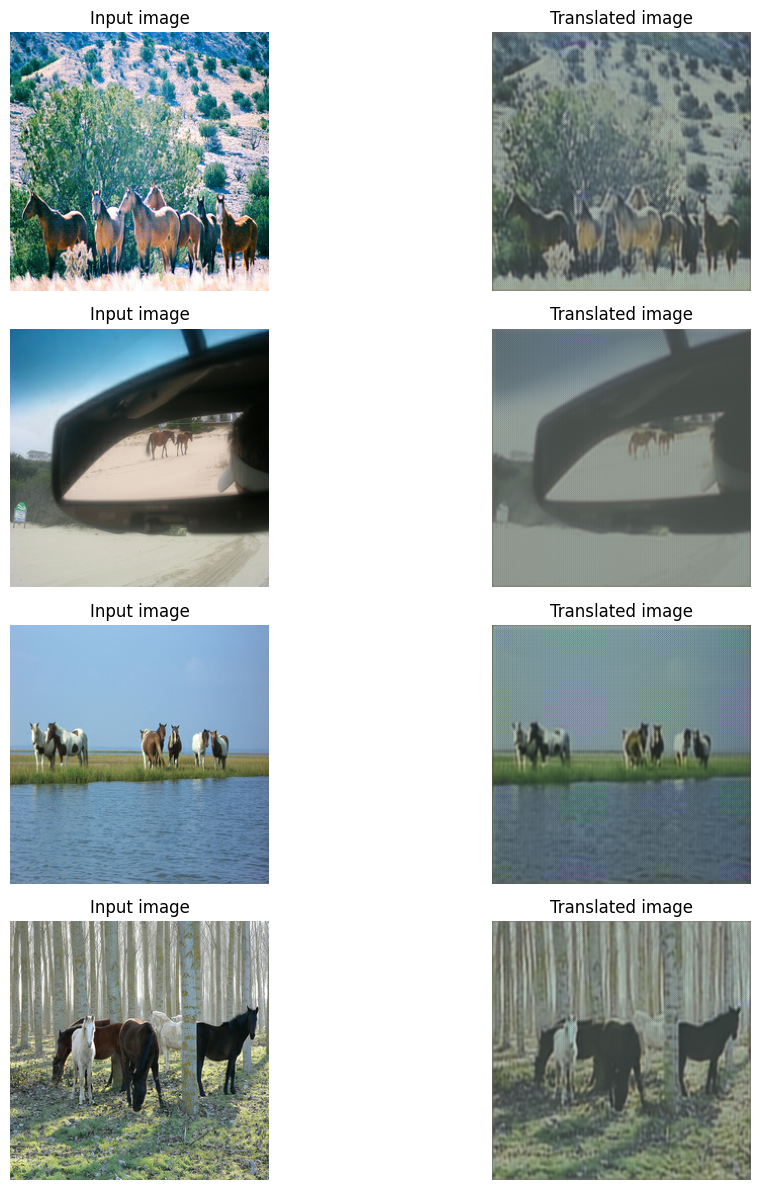

CPU times: user 9min 23s, sys: 5min 49s, total: 15min 13s
Wall time: 15min 24s


In [ ]:
%%time
train_history = train_loop(  # FIXME
        generator_G=gen_G,
        generator_F=gen_F,
        discriminator_X=disc_X,
        discriminator_Y=disc_Y,
        gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        generator_loss_fn=generator_loss_fn,
        discriminator_loss_fn=discriminator_loss_fn,
        cycle_loss_fn=cycle_loss_fn,
        identity_loss_fn=identity_loss_fn,
        train_gen_X=train_horses,
        train_gen_Y=train_zebras,
        test_gen_X=test_horses,
        test_gen_Y=test_zebras,
        lambda_cycle=10.0,
        lambda_identity=0.5,
        epochs=1)

In [ ]:
# Training takes approx 7 minutes / epoch on a modern GPU

## (6) Analyse des résultats

G_loss
F_loss
D_X_loss
D_Y_loss


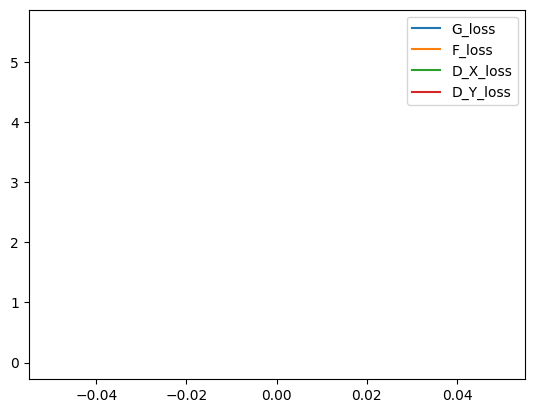

In [ ]:
# Plot training loss curves for each generator and discriminator
for k in train_history["history"].keys():
    print(k)
    plt.plot(np.arange(train_history["params"]["epochs"]), train_history["history"][k], label=k)

plt.legend()

NameError: name 'cycle_gan_model' is not defined

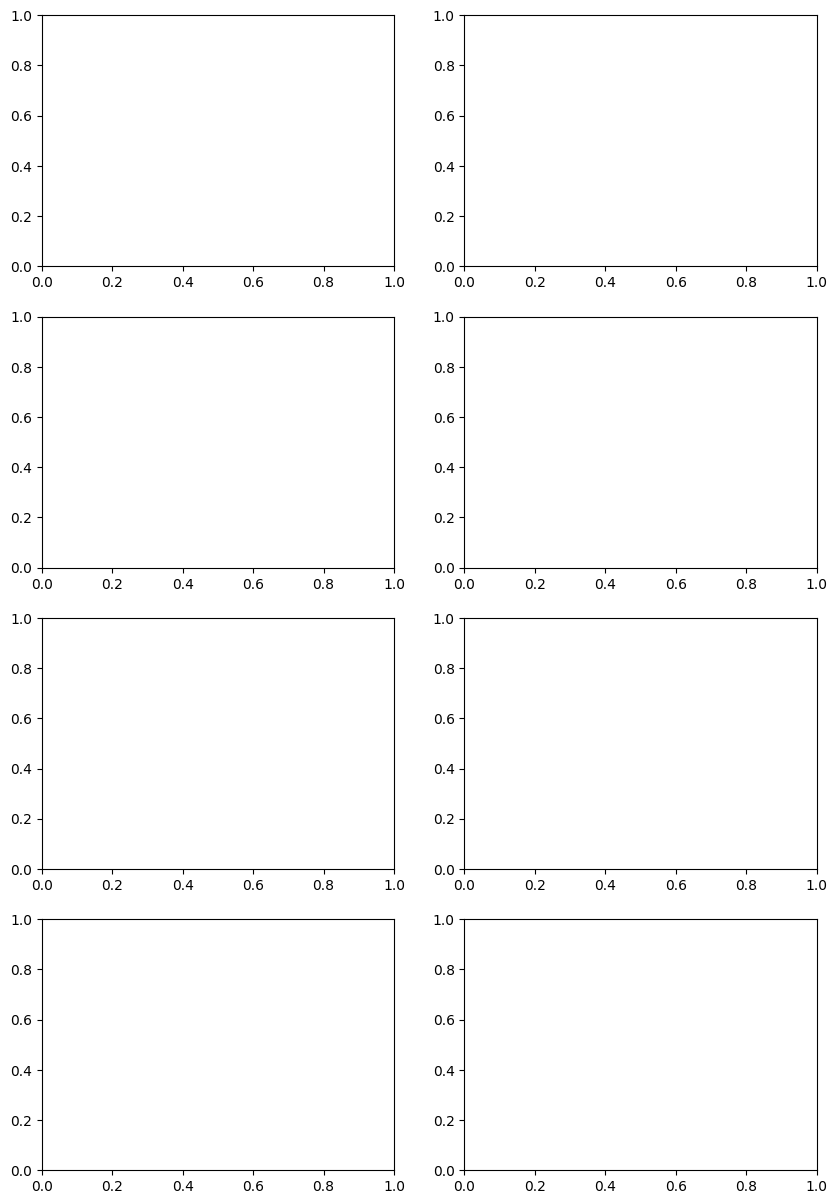

In [ ]:
# Compute generated image for some test samples
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_horses.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)  # Note the `training=False` here
    prediction = denormalize(prediction[0])
    img = denormalize(img[0])

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

## (7) Sauvegarde

On veut à présent sauvegarder les éléments utiles pour permettre :
- de générer des images à partir des générateurs pré-entraînés
- de poursuivre l'apprentissage.

Il faut donc sauvegarder les modèles et les états des optimiseurs.


In [ ]:
# TODO save the models
# gen_G.save("path/to/gen_g_epochs.ckpt")

In [ ]:
# TODO check saving worked by reloading some generator and making some predictions
# gen_G_reloaded = keras.load("...")

In [ ]:
# TODO save the optimizers
# model.optimizer.get_weights(???)